# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data files will be in the canvas assignment, merging them together.

Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Load the datasets
stats = pd.read_csv("nba_2025.txt", sep=",", encoding="latin-1")
salary = pd.read_csv("2025_salaries.csv", header=1, encoding="latin-1")
print(stats.head())
print(salary.head())

    Rk                   Player   Age Team Pos     G    GS      MP     FG  \
0  1.0  Shai Gilgeous-Alexander  27.0  OKC  PG  49.0  49.0  1632.0  534.0   
1  2.0             Tyrese Maxey  25.0  PHI  PG  52.0  52.0  2008.0  524.0   
2  3.0         Donovan Mitchell  29.0  CLE  SG  51.0  51.0  1719.0  516.0   
3  4.0             Jaylen Brown  29.0  BOS  SF  49.0  49.0  1676.0  534.0   
4  5.0            Luka DonÄiÄ  26.0  LAL  PG  42.0  42.0  1492.0  437.0   

      FGA  ...    TRB    AST    STL   BLK    TOV     PF     PTS  Trp-Dbl  \
0   964.0  ...  218.0  314.0   64.0  38.0  103.0  101.0  1558.0      0.0   
1  1117.0  ...  214.0  351.0  102.0  40.0  126.0  118.0  1503.0      0.0   
2  1060.0  ...  229.0  302.0   79.0  15.0  159.0  125.0  1478.0      0.0   
3  1105.0  ...  336.0  229.0   49.0  20.0  176.0  136.0  1435.0      2.0   
4   923.0  ...  329.0  360.0   61.0  19.0  179.0  102.0  1379.0      6.0   

   Awards  Player-additional  
0     NaN          gilgesh01  
1     NaN         

In [ ]:
# Clean player-name text by re-encoding/decoding as latin-1 and ignoring unsupported characters,
# which helps fix weird symbols from file encoding so merges/plots don’t break.
salary["Player"] = salary["Player"].astype(str).str.encode("latin-1", "ignore").str.decode("latin-1")
stats["Player"]  = stats["Player"].astype(str).str.encode("latin-1", "ignore").str.decode("latin-1")

In [ ]:
#Drop variables that will not be needed or are duplicates
merged_data = pd.merge(salary, stats, on='Player')
duplicates = merged_data[merged_data.duplicated(subset='Player', keep=False)]
duplicates.info()
# Convert the salary column from strings to a numeric value
salary["Salary"] = (
    salary["2025-26"]
    .astype(str)
    .str.replace(r"[^0-9.\-]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)
# Keep one row per player in salary by taking the maximum salary listed for that player
salary = (
    salary.groupby("Player", as_index=False)
          .agg({"Tm": "first", "Salary": "max"})
)
# Keep one row per player in stats (prevents duplicated players from skewing clustering)
stats = stats.drop_duplicates(subset="Player", keep="first")

# Merge again now that salary and stats are cleaned and deduplicated
merged_data = pd.merge(salary, stats, on="Player", how="inner")
print("Merged shape:", merged_data.shape)
merged_data.head()

<class 'pandas.DataFrame'>
Index: 166 entries, 0 to 522
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             166 non-null    str    
 1   Tm                 166 non-null    str    
 2   2025-26            157 non-null    str    
 3   Rk                 166 non-null    float64
 4   Age                166 non-null    float64
 5   Team               166 non-null    str    
 6   Pos                166 non-null    str    
 7   G                  166 non-null    float64
 8   GS                 166 non-null    float64
 9   MP                 166 non-null    float64
 10  FG                 166 non-null    float64
 11  FGA                166 non-null    float64
 12  FG%                165 non-null    float64
 13  3P                 166 non-null    float64
 14  3PA                166 non-null    float64
 15  3P%                154 non-null    float64
 16  2P                 166 non-null    float64

,Player,Tm,Salary,Rk,Age,Team,Pos,G,GS,MP,...,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional
0,A.J. Green,MIL,2301587.0,142.0,26.0,MIL,SG,49.0,49.0,1480.0,...,128.0,99.0,27.0,5.0,41.0,115.0,522.0,0.0,NaN,greenaj01
1,AJ Johnson,DAL,3090480.0,404.0,21.0,2TM,SG,28.0,0.0,225.0,...,32.0,23.0,7.0,0.0,18.0,15.0,70.0,0.0,NaN,johnsaj01
2,Aaron Gordon,DEN,22841455.0,193.0,30.0,DEN,PF,23.0,20.0,642.0,...,142.0,58.0,16.0,4.0,24.0,38.0,406.0,0.0,NaN,gordoaa01
3,Aaron Holiday,HOU,2296274.0,304.0,29.0,HOU,PG,35.0,1.0,465.0,...,30.0,34.0,16.0,4.0,21.0,47.0,200.0,0.0,NaN,holidaa01
4,Aaron Nesmith,IND,11000000.0,174.0,26.0,IND,SF,32.0,29.0,977.0,...,152.0,68.0,21.0,18.0,46.0,86.0,434.0,0.0,NaN,nesmiaa01


In [6]:
# Convert key stat columns to numeric in case any loaded as text
for col in ["G", "MP", "PTS", "AST", "TRB", "STL", "BLK", "TOV", "eFG%", "3P%", "FT%"]:
    if col in merged_data.columns:
        merged_data[col] = pd.to_numeric(merged_data[col], errors="coerce")

# Create per-game performance stats (more fair than season totals)
merged_data["MP_pg"]  = merged_data["MP"]  / merged_data["G"]
merged_data["PTS_pg"] = merged_data["PTS"] / merged_data["G"]
merged_data["AST_pg"] = merged_data["AST"] / merged_data["G"]
merged_data["TRB_pg"] = merged_data["TRB"] / merged_data["G"]
merged_data["STL_pg"] = merged_data["STL"] / merged_data["G"]
merged_data["BLK_pg"] = merged_data["BLK"] / merged_data["G"]
merged_data["TOV_pg"] = merged_data["TOV"] / merged_data["G"]

# Pick clustering features (performance only — NOT salary)
features = ["MP_pg", "PTS_pg", "AST_pg", "TRB_pg", "STL_pg", "BLK_pg", "TOV_pg", "eFG%", "3P%", "FT%"]

# Make X and fill missing values
X = merged_data[features].copy().fillna(merged_data[features].mean(numeric_only=True))

# Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Run the clustering algo with your best guess for K

# Pick an initial number of clusters to start with 
K_guess = 4

# Create the KMeans clustering model with K_guess clusters
model = KMeans(n_clusters=K_guess, random_state=42, n_init=20)

# Fit the model to the scaled performance data (X_scaled) and assign each player a cluster label
merged_data["cluster"] = model.fit_predict(X_scaled)


cluster
0    114
1     47
2    155
3     98
Name: count, dtype: int64


In [8]:
#View the results

# Prints how many players ended up in each cluster
print(merged_data["cluster"].value_counts().sort_index())

cluster
0    114
1     47
2    155
3     98
Name: count, dtype: int64


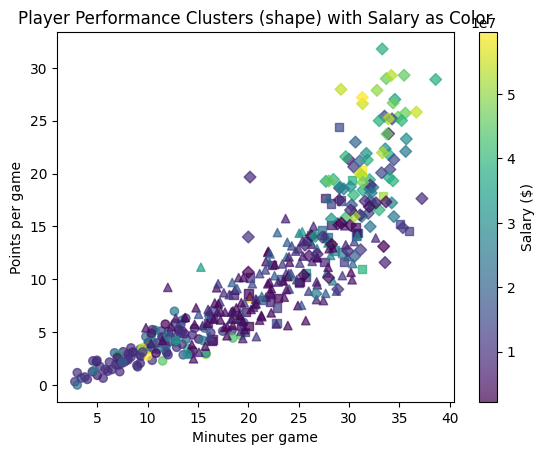

In [9]:
#Create a visualization of the results with 2 or 3 variables that you think will best
#differentiate the clusters

xcol = "MP_pg"   # minutes per game (usage/role proxy)
ycol = "PTS_pg"  # points per game (production proxy)

# Create a new figure for the plot
plt.figure()

# Define marker shapes so each cluster has a different shape
markers = ["o", "s", "^", "D", "P", "X"]

# Loop over each cluster value to plot each cluster with a different marker shape
for cl in sorted(merged_data["cluster"].unique()):
    # Subset the dataframe to only the players in this cluster
    sub = merged_data[merged_data["cluster"] == cl]
    # Scatter plot: x/y are performance, color is salary, marker shape is cluster
    plt.scatter(
        sub[xcol],
        sub[ycol],
        c=sub["Salary"],
        marker=markers[int(cl) % len(markers)],
        alpha=0.7
    )

# Label the x-axis 
plt.xlabel("Minutes per game")

# Label the y-axis 
plt.ylabel("Points per game")

# Add a title explaining what the plot is showing
plt.title("Player Performance Clusters (shape) with Salary as Color")

# Add a colorbar to show the mapping between color and salary dollars
cb = plt.colorbar()

# Label the colorbar so it's clear that color = salary
cb.set_label("Salary ($)")

# Display the plot
plt.show()

In [10]:
#Evaluate the quality of the clustering using total variance explained and silhouette scores

# Get the total sum of squares (TSS) for the scaled data:
TSS = np.sum((X_scaled - X_scaled.mean(axis=0))**2)

# Get the within-cluster sum of squares (WCSS), also called inertia, from the fitted KMeans model
WCSS = model.inertia_

# Compute the fraction of variance explained by the clustering
variance_explained = 1 - (WCSS / TSS)

# Print the variance explained 
print(f"Total variance explained (K={K_guess}): {variance_explained:.3f}")

# Compute the silhouette score
sil = silhouette_score(X_scaled, merged_data["cluster"])

# Print the silhouette score
print(f"Silhouette score (K={K_guess}): {sil:.3f}")

Total variance explained (K=4): 0.479
Silhouette score (K=4): 0.201


K=2 | inertia=2841.67 | silhouette=0.283
K=3 | inertia=2450.61 | silhouette=0.200
K=4 | inertia=2155.64 | silhouette=0.201
K=5 | inertia=1979.59 | silhouette=0.173
K=6 | inertia=1846.38 | silhouette=0.169
K=7 | inertia=1752.79 | silhouette=0.186
K=8 | inertia=1662.34 | silhouette=0.153


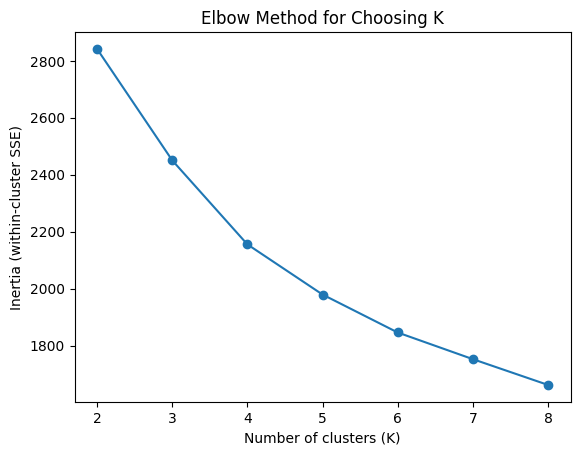

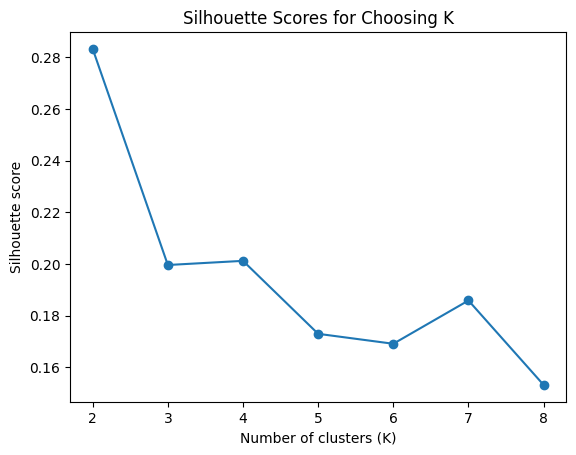

In [ ]:
# Determine the ideal number of clusters using the elbow method and the silhouette coefficient
# And visualize results of the elbow method

# Choose a range of K values to test 
k_values = range(2, 9)

# Create an empty list to store inertia (within-cluster SSE) for each K
inertias = []

# Create an empty list to store silhouette scores for each K
sil_scores = []

# Loop through each candidate K
for k in k_values:
    # Build a KMeans model with k clusters
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    # Fit KMeans and get cluster labels
    labels = km.fit_predict(X_scaled)
    # Store the inertia value for the elbow method
    inertias.append(km.inertia_)
    # Store the silhouette score to measure separation/quality
    sil_scores.append(silhouette_score(X_scaled, labels))

# Print a small table
for k, iner, sil in zip(k_values, inertias, sil_scores):
    print(f"K={k} | inertia={iner:.2f} | silhouette={sil:.3f}")

# Create a new figure for the elbow plot
plt.figure()

# Plot K vs inertia 
plt.plot(list(k_values), inertias, marker="o")

# Label the x-axis
plt.xlabel("Number of clusters (K)")

# Label the y-axis
plt.ylabel("Inertia (within-cluster SSE)")

# Title the plot
plt.title("Elbow Method for Choosing K")

# Show the elbow plot
plt.show()

# Create a new figure for the silhouette plot
plt.figure()

# Plot K vs silhouette score 
plt.plot(list(k_values), sil_scores, marker="o")

# Label the x-axis
plt.xlabel("Number of clusters (K)")

# Label the y-axis
plt.ylabel("Silhouette score")

# Title the plot
plt.title("Silhouette Scores for Choosing K")

# Show the silhouette plot
plt.show()

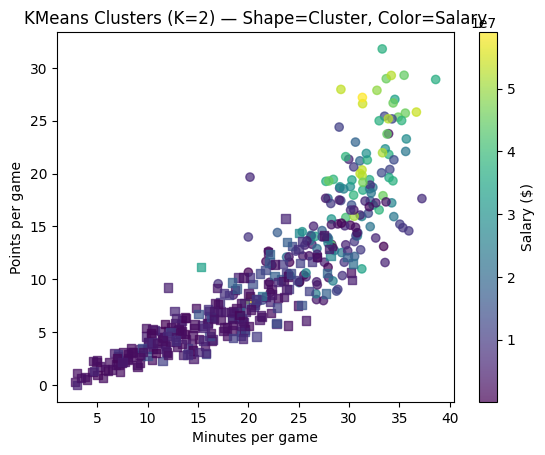

In [12]:
#Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

# Choose the recommended K:
# - Silhouette recommends K=2 (highest silhouette score in the output)
K_recommended = 2

# Create a new KMeans model using the recommended K
model_recommended = KMeans(n_clusters=K_recommended, random_state=42, n_init=20)

# Fit the model to the scaled performance data and store cluster labels
merged_data["cluster"] = model_recommended.fit_predict(X_scaled)

# Choose axes that make sense 
xcol = "MP_pg"   # minutes per game
ycol = "PTS_pg"  # points per game

# Create the plot
plt.figure()

# Marker shapes for clusters 
markers = ["o", "s", "^", "D", "P", "X", "*", "v"]

# Plot each cluster separately so each one has a different marker shape
for cl in sorted(merged_data["cluster"].unique()):
    sub = merged_data[merged_data["cluster"] == cl]
    plt.scatter(
        sub[xcol],
        sub[ycol],
        c=sub["Salary"],
        marker=markers[int(cl) % len(markers)],
        alpha=0.7
    )

# Label axes and title
plt.xlabel("Minutes per game")
plt.ylabel("Points per game")
plt.title(f"KMeans Clusters (K={K_recommended}) — Shape=Cluster, Color=Salary")

# Add salary colorbar
cb = plt.colorbar()
cb.set_label("Salary ($)")

# Show plot
plt.show()

In [13]:
#Once again evaluate the quality of the clustering using total variance explained and silhouette scores

# Total sum of squares (TSS): total variance in the dataset around the overall mean
TSS = np.sum((X_scaled - X_scaled.mean(axis=0))**2)

# Within-cluster sum of squares (WCSS): KMeans inertia 
WCSS = model_recommended.inertia_

# Total variance explained by clustering 
variance_explained = 1 - (WCSS / TSS)

# Silhouette score for the recommended K 
sil_recommended = silhouette_score(X_scaled, merged_data["cluster"])

# Print both metrics 
print(f"Variance explained (K={K_recommended}): {variance_explained:.3f}")
print(f"Silhouette score (K={K_recommended}): {sil_recommended:.3f}")

Variance explained (K=2): 0.314
Silhouette score (K=2): 0.283


In [18]:
#Use the model to select players for Mr. Rooney to consider

# Filter out players who don’t play real minutes 
pool = merged_data[(merged_data["MP_pg"] >= 20) & (merged_data["G"] >= 25)].copy()

# Compute expected salary by performance cluster, then residual (negative = underpaid)
pool["cluster_avg_salary"] = pool.groupby("cluster")["Salary"].transform("mean")
pool["salary_residual"] = pool["Salary"] - pool["cluster_avg_salary"]

# Cutoffs for categories (percentiles)
p10 = pool["salary_residual"].quantile(0.10)   # very underpaid
p25 = pool["salary_residual"].quantile(0.25)   # somewhat underpaid
p90 = pool["salary_residual"].quantile(0.90)   # very overpaid

# Pick 4 players per category
good_choices = pool[pool["salary_residual"] <= p10].nsmallest(4, "salary_residual")
could_work_choices = pool[(pool["salary_residual"] > p10) & (pool["salary_residual"] <= p25)].nsmallest(4, "salary_residual")
not_good_choices = pool[pool["salary_residual"] >= p90].nlargest(4, "salary_residual")

# Show results
cols = ["Player","Tm","Salary","cluster","cluster_avg_salary","salary_residual","MP_pg","PTS_pg","AST_pg","TRB_pg","eFG%"]

print("\n--- NOT GOOD choices ---")
display(not_good_choices[cols])

print("\n--- GOOD choices ---")
display(good_choices[cols])

print("\n--- COULD WORK choices ---")
display(could_work_choices[cols])


--- NOT GOOD choices ---


,Player,Tm,Salary,cluster,cluster_avg_salary,salary_residual,MP_pg,PTS_pg,AST_pg,TRB_pg,eFG%
364,Stephen Curry,GSW,59606817.0,0,2.120528e+07,3.840153e+07,31.333333,27.205128,4.846154,3.538462,0.585
205,Joel Embiid,PHI,55224526.0,0,2.120528e+07,3.401924e+07,31.354839,26.612903,3.903226,7.483871,0.528
244,Kevin Durant,HOU,54708609.0,0,2.120528e+07,3.350333e+07,36.700000,25.820000,4.440000,5.340000,0.570
135,Giannis Antetokounmpo,MIL,54126450.0,0,2.120528e+07,3.292117e+07,29.200000,27.966667,5.600000,10.033333,0.660



--- GOOD choices ---


,Player,Tm,Salary,cluster,cluster_avg_salary,salary_residual,MP_pg,PTS_pg,AST_pg,TRB_pg,eFG%
379,Toumani Camara,POR,2221677.0,0,2.120528e+07,-1.898361e+07,33.446429,13.107143,2.571429,5.357143,0.564
45,Brandon Williams,DAL,2270735.0,0,2.120528e+07,-1.893455e+07,22.000000,12.652174,3.673913,2.891304,0.494
75,Collin Gillespie,PHO,2296274.0,0,2.120528e+07,-1.890901e+07,28.277778,13.296296,4.685185,4.166667,0.576
348,Russell Westbrook,SAC,2296274.0,0,2.120528e+07,-1.890901e+07,29.250000,15.307692,6.576923,5.692308,0.509



--- COULD WORK choices ---


,Player,Tm,Salary,cluster,cluster_avg_salary,salary_residual,MP_pg,PTS_pg,AST_pg,TRB_pg,eFG%
50,Bub Carrington,WAS,4677600.0,0,2.120528e+07,-1.652768e+07,27.981132,10.150943,4.566038,3.528302,0.520
247,Kevin Porter Jr.,MIL,5134000.0,0,2.120528e+07,-1.607128e+07,33.678571,17.321429,7.607143,5.214286,0.500
99,Derik Queen,NOP,5157960.0,0,2.120528e+07,-1.604732e+07,26.036364,12.218182,4.145455,7.218182,0.506
256,Kris Dunn,LAC,5426400.0,0,2.120528e+07,-1.577888e+07,27.462963,7.981481,3.425926,2.888889,0.564


In [ ]:
# Write up the results in a separate notebook with supporting visualizations 
# and an overview of how and why you made the choices you did. 
# This should be at least 500 words and should be written for a non-technical audience.